<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG_596_FALL_21/blob/main/Filter_BUSI_UCLA_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2
import re #regexp for BUSI files
from skimage import exposure  #image equalization
import torchvision.transforms as transforms #for imagenet specific stage2 normalization

################################################################################
#ULTRASOUND NEEDS
import PIL
#from PIL import Image
# Open the image form working directory
#image = Image.open(full_file)

from matplotlib import image
from ast import literal_eval #used to break out bounding boxes from strings
import time


from numpy import clip

################################################################################

eps = 1e-16 #keep div by 0 away


from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image array
import shutil #copy file libraries

################################################################################
# Load data from google drive
################################################################################
drive.mount('/content/gdrive')

#
# Setup of input and output drives
#

#
# Choose training sets to use
#
training_set = 0 #0=UCLA US, 1 = UCLA + BUSI, 2 = BUSI

#storage areas 
data_dir = '/content/gdrive/Shareddrives/BreastUS'
local_dir = '/content/gdrive/My Drive/BreastUS' #for local storage
model_dir = '/content/gdrive/My Drive/BreastUS/MODEL_SAVE'
tensorboard_dir =  '/content/gdrive/My Drive/BreastUS/TENSORBOARD_SUMMARIES'


#
# UCLA specific data folders
#
csv_dir = os.path.join(data_dir,'Annotated data')

annotated_dir = os.path.join(data_dir,'Annotated data')

data_files = os.listdir(annotated_dir)
label_data_dir = os.path.join(annotated_dir,'LabelMe_3.0_format_updated')
label_files = os.listdir(label_data_dir)

#
# Alternative set of Ultrasound data
#
busi_main_dir = '/content/gdrive/My Drive/BreastUS/BUSI_DATA' #downloaded BUSI

#output converted BUSI images go in here:
norm_dir = '0TO1NORM'  #-2 to 2 norm method is N2TO2_NORM\

busi_converted_main_dir = os.path.join('/content/gdrive/My Drive/BreastUS/',norm_dir,'BUSI_DATA_CONTRAST_EQUALIZED')
ucla_converted_main_dir = os.path.join('/content/gdrive/My Drive/BreastUS/',norm_dir,'UCLA_DATA_CONTRAST_EQUALIZED')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
if(os.path.exists(busi_converted_main_dir)):
    print('BUSI Contrasted folder found')
else:
    os.mkdir(busi_converted_main_dir)

if(os.path.exists(ucla_converted_main_dir)):
    print('BUSI Contrasted folder found')
else:
    os.mkdir(ucla_converted_main_dir)


BUSI Contrasted folder found


In [3]:
if (0): #debug some transforms
    full_file = os.path.join(busi_main_dir,category, filename)
    img_data = image.imread(full_file)
    nr,nc,nz = np.shape(img_data)
    print(nr,nc,nz)
    #img = pickle.load( open( full_file, "rb" ) )
    import torchvision.transforms as transforms

    plt.figure()
    plt.imshow(img_data[:,:,0], cmap='gray')
    plt.title('original')
    plt.colorbar()
    m1 = img_data.mean()


    cropped_image = img_data
    minvals = np.min(cropped_image)
    maxvals = np.max(cropped_image)
    stdvals = np.std(cropped_image)
    print('min,max,std = ', minvals, maxvals, stdvals)

    cropped_image = (cropped_image - cropped_image.min()) / (cropped_image.max() - cropped_image.min() + eps)
    #cropped_image = (cropped_image - cropped_image.mean()) / (cropped_image.std() + eps)
    #cropped_image = clip(cropped_image, -1.0, 1.0)
    #cropped_image = (cropped_image + 1.0) / 2.0 

    print('new min,max,std = ',np.min(cropped_image), np.max(cropped_image), np.std(cropped_image))

    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) ])

    transform2 = transforms.Compose([
        transforms.ToTensor() ])

    print('shape before transform = ', np.shape(cropped_image))
    cropped_image = transform2(cropped_image)
    print('type of transform is ', type(cropped_image))


    plt.figure()
    plt.imshow(cropped_image[0,:,:,], cmap='gray')
    plt.colorbar()

#READ CSV DATA

In [4]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

#GET UCLA CSV INFORMATION

In [5]:
def get_ucla_csv(csv_dir):
    #READ CSV FILES
    #pull out the box information and label info
    csv_list = os.listdir(csv_dir)

    for csv_file in csv_list:
        filename = os.path.join(csv_dir,csv_file)
        if (os.path.isdir(filename) == 1):
            #skip any directories found in list
            continue
        if ('_final' in csv_file):
            annotation_fields, annotation_rows = get_csv_data(filename)

        else:
            print('Non-archive file found ',filename)
    return annotation_fields, annotation_rows

#SORT UCLA CSV FIELDS

In [6]:
def sort_UCLA_csv(annotation_rows, annotation_fields):
    print(np.shape(annotation_rows))

    print(annotation_fields)

    array_rows = np.array(annotation_rows)
    mrn = array_rows[:,1]
    accession = array_rows[:,2]
    video_id = array_rows[:,3]
    frame_id = array_rows[:,4]
    image_path = array_rows[:,5]
    bounding_box = array_rows[:,6]
    diagnosis = array_rows[:,7]
    biopsy_site = array_rows[:,8]
    diagnosis2 = array_rows[:,9]
    first50 = array_rows[:,10]

    return array_rows, mrn, accession, video_id, frame_id, image_path, bounding_box, \
        diagnosis, biopsy_site, diagnosis2, first50

In [7]:
def extract_edge(binary_image,npoint, center,roworcol):
    #
    # Get valid columns/rows from image
    # roworcol = 0 is row, 1 = column

    
    point = [0,npoint]
    edges =[]
    
    for ii in point:
        max_line = 0
        max_default = 1e6
        #print(' ii, center = ', ii, center)
        if (center > ii):
            step = -1
            heading = 0
        else:
            step = 1
            heading = npoint


        for line in range(center,heading,step):
            #nr,nc = np.shape(binary_image)
            #print('bin image = ', binary_image)
            if (roworcol == 0):
                max_vals = np.sum(binary_image[line,:])
            else:
                max_vals = np.sum(binary_image[:,line])
            #print(line, max_vals, roworcol)
            if (max_vals < max_default):
                max_default= max_vals
                max_line = line
            if (max_vals < 250):
                #this is likely outside the core subimage
                break
        #print('max default = ',max_default)
        #print('max line = ',max_line)
        edges.append(max_line)

    status = 1
    if (len(edges) <2):
        edges = [0,0]
        status = 0

    return edges, status

#UCLA BBOX AND VIDEO STATS

In [8]:
def video_stats(training_set, video_id, bounding_box):
    if (training_set in [0,1]):
        #generate stats on bounding boxes
        uvids = set(video_id)

        box_collect=[]
        frames_collect=[]
        empty_annotations=[]
        for count, v in enumerate(uvids):
            number_frames = 0
            number_boxes = 0
            
            #print('---- loading: ', v)
            for icount,ii in enumerate(video_id):
                if (ii == v):
                    box_info = bounding_box[icount]
                    number_frames+=1
                    if (not (box_info =='[]')):
                        number_boxes+=1
                    else:
                        pass
                        #print('no annotation', frame_id[icount])
            frames_collect.append(number_frames)
            box_collect.append(number_boxes)
            #print(v,number_frames,number_boxes)
            if (number_boxes == 0):
                empty_annotations.append(v)




        print('Number of videos: ',np.size(frames_collect[:]))
        print('Number of annotated cases ',np.size(box_collect))
        print('Videos with no Annotations:', empty_annotations)
            #get_bb_stats(v, video_id,bounding_box, image_path)
    else:
        print('Skipping Bounding box statistics for UCLA data')

#IMAGENET NORMALIZATION

In [9]:
#Imagenet requires a specific Norm to 0,1 then norm with the mean and std from 
#the large imagenet dataset
##### NOTE: ToTensor() converts to float32 tensor and adjusts range to 0,1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]) ])

#GO THROUGH BUSI DATA FOLDERS

In [10]:
if (training_set ==2):
    print('--- Loading BUSI Data Files and Categorizing')
    busi_dirs = os.listdir(busi_main_dir)
    print('busi directories: ', busi_dirs)

    #busi_m_files = os.listdir(os.path.join(busi_main_dir, 'malignant')) #bus_dirs['malignant']))

    if(os.path.isdir(busi_converted_main_dir) == False):
        #if output dir isn't here, create it
        print('Output directory not found. Creating it')
        os.mkdir(busi_converted_main_dir)
    else:
        print('Found output main BUSI directory')

    full_pickle_list =[]
    counter = 0
    for category in busi_dirs:
        busi_files = os.listdir(os.path.join(busi_main_dir, category))
        
        subdir = os.path.join(busi_converted_main_dir, category)
        if(os.path.isdir(subdir) == False):
            #if output dir isn't here, create it
            print('Output sub directory not found. Creating it ', subdir)
            os.mkdir(subdir)
        else:
            print('Found sub directory ',subdir)


        for filename in busi_files:
            if ('mask' in filename):
                mask_file = os.path.join(busi_main_dir, category, filename)
                print('mask input is ', mask_file)
                shutil.copy2(mask_file, 
                             os.path.join(busi_converted_main_dir,category))
                
            else:
                
                counter +=1
                temp= filename.split(' ')
                number = re.findall('\d+',temp[1])
                number = int(number[0])
                full_file = os.path.join(busi_main_dir,category, filename)



                #if reading in by RGB and doing manual matplotlib conversion,
                #use this to read in all three channels. The new method is to
                #use opencv and do the conversion via that function. This 
                #removes the z axis
                #img_data = image.imread(full_file)
                #nr_original,nc_original,nz = np.shape(img_data)

                #
                ## Convert the RGB input into grayscale
                #
                #R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
                #imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

                imgGray = cv2.imread(full_file,cv2.IMREAD_GRAYSCALE)
                nr_original,nc_original = np.shape(imgGray)

                print('file is ', full_file)
                print('image shape read in is ',np.shape(imgGray))


                cropped_image = imgGray #BUSI is pre-cropped

                cropped_image = cv2.resize(cropped_image,
                                        dsize=(800,600), #(480,600)
                                        interpolation=cv2.INTER_CUBIC)


                #
                # Simple min/max normalization. The opencv grayscale image turns
                # the raw RGB 0 to 1 intensity into grayscale 0 to 255 intensity
                # This needs to be normalized back to 0 to 1
                #
                cropped_image = (cropped_image - cropped_image.min()) / (cropped_image.max() - cropped_image.min() + eps)
            

                # Adaptive Equalization
                #returns float64
                print('min,max of image = ', np.min(cropped_image), np.max(cropped_image))
                cropped_image = exposure.equalize_adapthist(cropped_image, clip_limit=0.01)

                #Resnet requires float32 inputs
                cropped_image = np.float32(cropped_image)
                #normalize back to 0,1
                '''
                minvals = np.min(cropped_image)
                maxvals = np.max(cropped_image)
                stdvals = np.std(cropped_image)
                if maxvals > 1:
                    cropped_image = (cropped_image - cropped_image.min()) / (cropped_image.max() - cropped_image.min() + eps)
                cropped_image = (cropped_image - cropped_image.mean()) / (cropped_image.std() + eps)
                cropped_image = clip(cropped_image, -1.0, 1.0)
                cropped_image = (cropped_image + 1.0) / 2.0   
                '''

                nr,nc = np.shape(cropped_image) #this is the new resized image


                noise = np.random.normal(0.5, .1, cropped_image.shape)
                noisey_cropped_image = cropped_image + noise
                noisey_cropped_image = np.clip(noisey_cropped_image,0.0,1.0)
                noise = np.random.normal(0.5, .01, cropped_image.shape)
                noisey_cropped_image2 = cropped_image + noise
                noisey_cropped_image2 = np.clip(noisey_cropped_image2,0.0,1.0)

                '''
                img = np.zeros((3,600,800), dtype=np.double)  #600,480), dtype=np.double) #nr,nc))

                img[0,:,:] = noisey_cropped_image#.astype(np.double)
                img[1,:,:] = cropped_image#.astype(np.double)
                img[2,:,:] = noisey_cropped_image2#.astype(np.double)
                '''


                #changed to HxWxC for the transform!!
                img = np.zeros((600,800,3), dtype=np.double)  #600,480), dtype=np.double) #nr,nc))
                #
                img[:,:,0] = noisey_cropped_image#.astype(np.double)
                img[:,:,1] = cropped_image#.astype(np.double)
                img[:,:,2] = noisey_cropped_image2#.astype(np.double)
                
                
                #ImageNet second normalization step
                # -- not needed, since we are simply using the 0,1 norm instead
                #    of what ImageNet uses
                #cropped_image = transform(img)
                cropped_image = img


                print('type of tensor is ', type(cropped_image[0]))

                '''
                plt.figure()
                plt.imshow(imgGray,cmap='gray')
                plt.colorbar()

                plt.figure()
                plt.imshow(img[:,:,1], cmap='gray')
                plt.colorbar()
                stop
                '''

                    
                pickle_name = filename + '_' + str(nr_original) + '_' + str(nc_original) +'.pck'
                out_file = os.path.join(busi_converted_main_dir, category, pickle_name)
                full_pickle_list.append(out_file)

                pickle.dump(cropped_image,open( out_file, "wb" ),protocol=5 )

                #image.imsave(out_file, cropped_image)


        print('Done with category: ', category)
    print('Done parsing BUSI data. #files total = ', counter)

################################################################################
#
#                              UCLA DATA
#
################################################################################
elif (training_set == 0): #UCLA Datasets
    print('starting UCLA conversion')
    dbprint =0
    full_pickle_list=[] #store files sent to pickle

    print('--- Loading UCLA Data Files and Categorizing')
    data_dirs = os.listdir(busi_main_dir)
    print('UCLA directories: ', data_dirs)



    annotation_fields, annotation_rows= get_ucla_csv(csv_dir)
    array_rows, mrn, accession, video_id, frame_id, image_path, bounding_box, \
        diagnosis, biopsy_site, diagnosis2, first50 = sort_UCLA_csv(annotation_rows, annotation_fields)


    ############################################################################
    # Get Folder data
    ############################################################################
    full_file_list=[]

    for file_path in image_path:
        #print(file_path)

        filename = os.path.basename(file_path) 
        [_,fpath] =file_path.split('drive/MyDrive/Annotated data/')
        full_file = os.path.join(annotated_dir,fpath)
        full_file_list.append(full_file)
    print('Number of US files: ', len(full_file_list))
    original_file_length = len(full_file_list)

    video_stats(training_set, video_id, bounding_box)

    ############################################################################
    #
    # Default string subsets for replacement for UCLA folders
    # -to replace the CSV given names
    old_string = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated'
    new_string = ucla_converted_main_dir



    ############################################################################
    # Convert each file:
    # crop, normalize, contrast adjust
    #
    for fcount,fname in enumerate(full_file_list):
        filename = os.path.basename(fname) #filename without full pathing
        converted_name = fname.replace(old_string, new_string)
        subpath = os.path.dirname(converted_name)
        #os.makedirs(subpath)
        if (os.path.isdir(subpath)):
            pass
            #print(converted_name)
        else: #directory not found, create it
            os.makedirs(subpath)
            print('Making new directory ', subpath)


        #img_data = image.imread(fname)
        #nr_original,nc_original, nz = np.shape(img_data) #used for filename creation
        

        imgGray = cv2.imread(full_file,cv2.IMREAD_GRAYSCALE)
        nr_original,nc_original = np.shape(imgGray)


        fail_crop = 0 #toggle if cropping fails to alert that this img is bad

        ########################################################################
        ## Convert the RGB input into grayscale
        ########################################################################
        #R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        #imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

        use_crop_style = 1 #try simpler cropping

        if (use_crop_style == 1):
        # SIMPLE CROPPING ######################################################
        ##skip_points = [low_row, high_row,start_column, final_column]
            binary_image = (imgGray>0).astype(int)
            nr,nc = np.shape(binary_image)
            cen_row = np.uint(nr/2)
            cen_col = np.uint(nc/2)

            column_edges, cstatus= extract_edge(binary_image, nc, cen_col,roworcol=1)
            row_edges, rstatus =  extract_edge(binary_image, nr,cen_row,roworcol=0)

            if ((cstatus == 0) or (rstatus == 0)):
                print('-----failed crop')
                fail_crop =1
            skip_points = [row_edges[0]-1, row_edges[1]+1, column_edges[0]-1, column_edges[1]+1]
            cropped_image = imgGray[row_edges[0]:row_edges[1], column_edges[0]:column_edges[1]]
            
            if (np.size(cropped_image) <1):
                print('!!!!!!!!!!!!!!!!!!!Failure during crop. 800x600 set for ', fname)
                print('SKIPPING FILE ABOVE')
                continue
                #we should exit out, but put a fake image for now
                #cropped_image = np.zeros((800,600))
                stop
        ########################################################################
        else:
            print('!!!!!! Incorrect crop selection received.Exit')
            exit()

        ########################DEBUG ONLY
        saved_image =    cropped_image

        ##########################################

        if (dbprint == 1):
            print('about to resize image. shape going in is @index',
                np.shape(imgGray),np.shape(cropped_image), index)
        
        #array indexing is easier to deal with
        cropped_image = np.array(cropped_image)

        if (dbprint == 1):
            print('image after crop is ', np.shape(cropped_image))

        oldr,oldc = np.shape(cropped_image) #image shape before resize
        cropped_image = cv2.resize(cropped_image,
                                dsize=(800,600), #(480,600)
                                interpolation=cv2.INTER_CUBIC)



        # Adaptive Equalization
        #returns float64
        #print('min,max of image = ', np.min(cropped_image), np.max(cropped_image))
        cropped_image = exposure.equalize_adapthist(cropped_image, clip_limit=0.01)

        #Resnet requires float32 inputs
        cropped_image = np.float32(cropped_image)

        

        '''
        plt.figure()
        plt.imshow(saved_image, cmap='gray')
        plt.colorbar()
        plt.title('original')

        plt.figure()
        plt.imshow(cropped_image, cmap='gray')
        plt.colorbar()
        plt.title('equalized')

        plt.figure()
        plt.hist(cropped_image)
        '''
        

        if (dbprint == 1):
            print('resized shapes are ',nr,nc)
            print('scale factors x,y = ',box_scalex,box_scaley)
        '''
        img = np.zeros((3,600,480), dtype=torch.DoubleTensor) #nr,nc))
        img[0,:,:] = cropped_image.astype(torch.DoubleTensor)
        img[1,:,:] = cropped_image.astype(torch.DoubleTensor)
        img[2,:,:] = cropped_image.astype(torch.DoubleTensor)
        '''

        noise = np.random.normal(0.5, .1, cropped_image.shape)
        noisey_cropped_image = cropped_image + noise
        noisey_cropped_image = np.clip(noisey_cropped_image,0.0,1.0)
        noise = np.random.normal(0.5, .01, cropped_image.shape)
        noisey_cropped_image2 = cropped_image + noise
        noisey_cropped_image2 = np.clip(noisey_cropped_image2,0.0,1.0)


        #changed to HxWxC for the transform.totensor!!
        img = np.zeros((600,800,3), dtype=np.double)  #600,480), dtype=np.double) #nr,nc))
        #
        img[:,:,0] = noisey_cropped_image#.astype(np.double)
        img[:,:,1] = cropped_image#.astype(np.double)
        img[:,:,2] = noisey_cropped_image2#.astype(np.double)

        cropped_image = img

        ########################################################################
        # Normalization Methods
        ########################################################################
        cropped_image = (cropped_image - cropped_image.min()) / (cropped_image.max() - cropped_image.min() + eps)
    

        ########################################################################
        #ImageNet second normalization step
        ########################################################################
        #cropped_image = transform(img)




        #Skip points added to filename for use in annotation repositioning
        pickle_name = filename + '_' + str(nr_original) + '_' + str(nc_original) +'_' \
            +str(skip_points[0]) +'_' +str(skip_points[1]) +'_' +str(skip_points[2]) +'_' +str(skip_points[3]) +'.pck'
        out_file = os.path.join(subpath, pickle_name)
        full_pickle_list.append(out_file)

        pickle.dump(cropped_image,open( out_file, "wb" ),protocol=5 )

        if (fcount %500 == 0):
            print('Processed file # w/shape = ',fcount, np.shape(cropped_image))

else:
    print('incorrect data source sent in')

            

print('!!! Finished Processing IMAGE Data !!!')



starting UCLA conversion
--- Loading UCLA Data Files and Categorizing
UCLA directories:  ['malignant', 'normal', 'benign']
found rows: 8843
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated.csv
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/unzipfiles.py
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/UnzipFiles.ipynb
(8842, 11)
['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']
Number of US files:  8842
Number of videos:  102
Number of annotated cases  102
Videos with no Annotations: ['1_jq3lf35n_a_12h3r1u8_0.mp4-2021_07_15_17_21_32-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_5.mp4-2021_07_15_17_21_17-labelme 3.0.zip', '1_2w948u10_a_06g91d42_0.mp4-2021_07_15_17_21_18-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_2.mp4-2021_07_15_17_21_26-labelme 3.0.zip', '1_2w948u10_a_06g91d42_5.mp4-202

#Test sample BUSI images after pickle

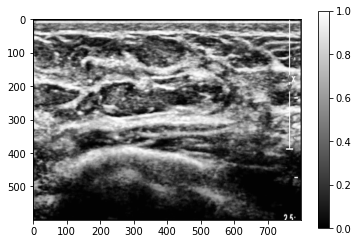

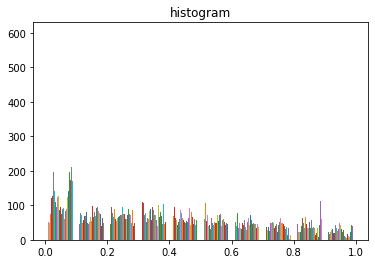

In [13]:
#vdata = pickle.load( open( validation_loss_file, "rb" ) )
if (training_set == 2):

    fname = full_pickle_list[50]
    img = pickle.load( open( fname, "rb" ) )

    plt.figure()
    plt.imshow(img[:,:,1],cmap='gray')
    plt.colorbar()

else:
    fname = full_pickle_list[5000]
    img = pickle.load( open( fname, "rb" ) )

    plt.figure()
    plt.imshow(img[:,:,1],cmap='gray')
    plt.colorbar()

    plt.figure()
    plt.hist(img[:,:,1])
    plt.title('histogram')

In [14]:
len(full_pickle_list)
print(ucla_converted_main_dir)
pfile = '/content/gdrive/My Drive/BreastUS/ucla_converted_files_pickle_list.pck'
pickle.dump(full_pickle_list,open( pfile, "wb" ),protocol=5 )

/content/gdrive/My Drive/BreastUS/0TO1NORM/UCLA_DATA_CONTRAST_EQUALIZED
